In [ ]:
import tensorflow as tf

from quadratic import quadratic_data, quadratic_task
from model import LSTMOpt

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd, rmsprop

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11,6)
plt.style.use('default')

In [ ]:
def f(theta):
    """
    with the current value of w and y, the function calculates value
    of the function at theta
    """
    return np.mean(np.sum((w@theta-y)**2, axis=1))
    
def grad_func(theta, iter=0):
    """
    autograd gradient of f at theta
    """
    return grad(f)(theta)

In [ ]:
class CustomLoss(tf.keras.losses.Loss):
    """
    A custom loss that's equivalent to the function value i.e., loss at a value of theta.
    """
    def __init__(self, seed, batch_size=128, dim=10):
        super().__init__()
        npr.seed(seed)
        self.w = npr.normal(loc=0.0, scale=1e0, size=(batch_size,dim,dim))
        self.y = npr.normal(loc=0.0, scale=1e0, size=(batch_size,dim,1))
        
    def call(self, theta, required=None):
        return tf.math.reduce_mean(tf.math.reduce_sum((self.w@theta-self.y)**2, axis=1))

#### Training the LSTM Optimizer

In [ ]:
%%time
lstmopt = LSTMOpt()
meta_optimizer = tf.keras.optimizers.Adam(0.001)

iter = 200
steps = 150
num_unrolls = 20
states = None

losses = np.zeros((iter, steps))
seeds = range(iter)

for i, seed in enumerate(seeds):
    
    print(i+1, end='')
    w, y, theta = quadratic_data(seed)
    grad_f = grad_func(theta)
    loss = CustomLoss(seed)
    
    for _ in range(steps):

        losses[i,_] = f(theta)
        sum_losses = tf.zeros(())

        for _ in range(num_unrolls):        
            with tf.GradientTape() as tape:
                update, states = lstmopt(grad_f, states)
                theta = update
                sum_losses += loss(theta, None)
            grad_f = grad_func(theta.numpy())

        lstm_grads = tape.gradient(sum_losses, lstmopt.variables)
        meta_optimizer.apply_gradients(zip(lstm_grads, lstmopt.variables))

In [46]:
lstmopt.summary()

Model: "lstm_opt_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               multiple                  2480      
                                                                 
 lstm_9 (LSTM)               multiple                  3280      
                                                                 
 10 dim update (Dense)       multiple                  210       
                                                                 
Total params: 5,970
Trainable params: 5,970
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstmopt.save_weights('models/lstmopt.h5')

#### Testing the optimizer

In [ ]:
lstmopt.load_weights('models/lstmopt.h5')

In [ ]:
states=None
num_steps = 150
num_times = 200

losses_lstm = np.zeros((num_times, num_steps))
npr.seed(0)
seeds = npr.choice(range(500,1000), size=num_times, replace=False)

In [ ]:
for i,seed in enumerate(seeds):
    print(i+1, end=' ')
    w, y, theta = quadratic_data(seed)
    grad_f = grad_func(theta)

    for j in range(num_steps):

        losses_lstm[i,j] = f(theta)
        theta, states = lstmopt(grad_f, states)  
        grad_f = grad_func(theta.numpy())

mean_losses_lstm = np.mean(losses_lstm, axis = 0)

#### Comparing the LSTM Optimizer with Adam optimizer for different learning rates

In [ ]:
lrs = [0.003, 0.05, 0.1, 0.9, 1.5]
losses_adam = np.zeros((len(lrs), num_times, num_steps))

npr.seed(0)
seeds = npr.choice(range(500,1000), size=num_times, replace=False)

for j,lr in enumerate(lrs):
    
    def callback(params, iter, gradient):
            losses_adam[j, i, iter] = f(params)


    for i,seed in enumerate(seeds):

        w, y, theta = quadratic_data(seed)
        grad_f = grad_func(theta)
        theta = adam(grad_func, 
                      theta,
                      step_size=lr, 
                      num_iters=num_steps, 
                      callback=callback);

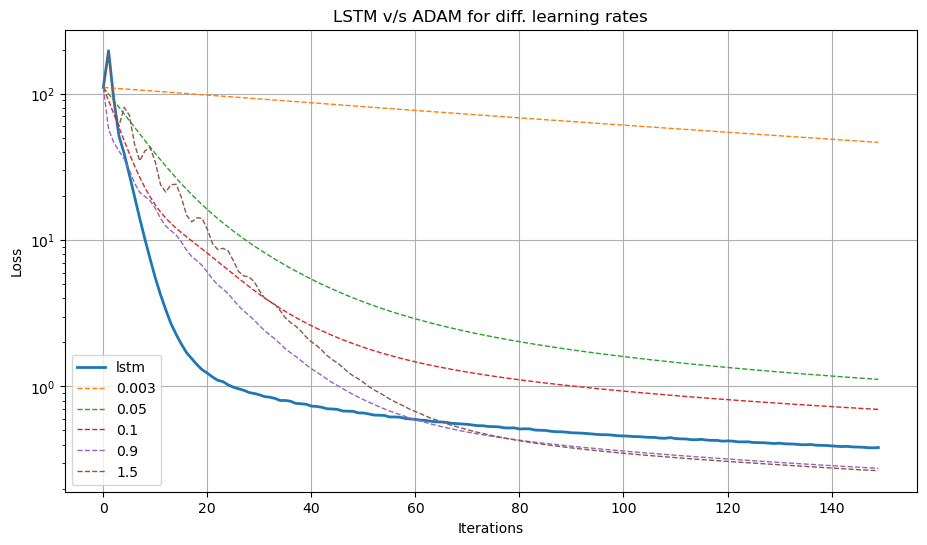

In [37]:
plt.rcParams['figure.figsize'] = (11,6)
plt.figure()
plt.semilogy(mean_losses_lstm, label='lstm', linewidth=2)

for j,lr in enumerate(lrs):
    mean_losses_adam = np.mean(losses_adam[j], axis=0)
    plt.semilogy(mean_losses_adam, label=lr, linestyle = '--', linewidth=1)
    
plt.legend()
plt.grid()
plt.title('LSTM v/s ADAM for diff. learning rates')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()